In [5]:
import pydot
import matplotlib.pyplot as plt
import time
import math
import random
from sklearn.manifold import MDS
import numpy as np
import plotly.graph_objs as go
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap


In [7]:
def get_data_step6(dot_file_path):
    with open(dot_file_path, 'r') as dot_file:
        dot_data = dot_file.read()
    graph = pydot.graph_from_dot_data(dot_data)

    nodes = graph[0].get_nodes()
    edges = graph[0].get_edges()
    
    node_list = [node.get_name() for node in nodes]
    edge_list = [(edge.get_source(), edge.get_destination()) for edge in edges]
    weights = {}
    if edges[0].get_attributes()!={}:
        name= str(list(edges[0].get_attributes().keys())[0])
        weights = {(edge.get_source(), edge.get_destination()):int(edge.get_attributes()[name]) for edge in edges}

    return nodes,edges,node_list,edge_list,weights

In [8]:
def get_data_jazz(dot_file_path):
    with open(dot_file_path, 'r') as dot_file:
        dot_data = dot_file.read()
    graph = pydot.graph_from_dot_data(dot_data)

    nodes = graph[0].get_nodes()
    edges = graph[0].get_edges()
    
    node_list = [node.get_name() for node in nodes]
    edge_list = [(edge.get_source(), edge.get_destination()) for edge in edges]
    weights = {(edge.get_source(), edge.get_destination()):1 for edge in edges}
    
    return nodes,edges,node_list,edge_list,weights

# Floyd Warshall

In [9]:
def floyd_warshall(node_list, edge_list, weights):
    num_nodes = len(node_list)
    
    distances = np.full((num_nodes, num_nodes), np.inf)
    np.fill_diagonal(distances, 0)

    for (u, v), weight in weights.items():
        i = node_list.index(u)
        j = node_list.index(v)
        distances[i, j] = weight
        distances[j, i] = weight  #graph is undirected

    for k in range(num_nodes):
        for i in range(num_nodes):
            for j in range(num_nodes):
                distances[i, j] = min(distances[i, j], distances[i, k] + distances[k, j])

    return distances

# T-SNE

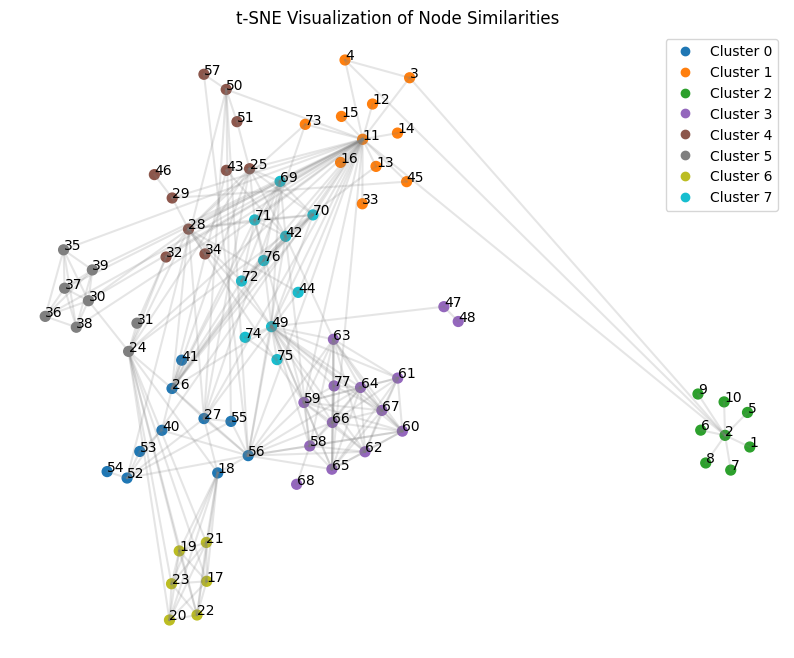

In [17]:
def plot_tsne(distances, node_list, edge_list, perplexity=10, learning_rate=300, n_iter=1000, interactive=False):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, init='random', metric='precomputed')
    embeddings = tsne.fit_transform(distances)
    
    kmeans = KMeans(n_clusters=8) 
    labels = kmeans.fit_predict(embeddings)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='tab10', s=50, vmin=0, vmax=7) 

    for edge in edge_list:
        u, v = edge
        u_index = node_list.index(u)
        v_index = node_list.index(v)
        plt.plot([embeddings[u_index, 0], embeddings[v_index, 0]], 
                 [embeddings[u_index, 1], embeddings[v_index, 1]], 
                 color='gray', alpha=0.2)

    for i, node_number in enumerate(node_list):
        plt.text(embeddings[i, 0], embeddings[i, 1], node_number, color='black')

    plt.axis('off')
    plt.title('t-SNE Visualization of Node Similarities')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    
    handles, labels = scatter.legend_elements()
    plt.legend(handles, [f'Cluster {i}' for i in range(len(handles))], loc='upper right')

    plt.show()

#nodes,edges,node_list,edge_list,weights = get_data_step6('Datasets/LesMiserables.dot')
#distances = floyd_warshall(node_list, edge_list, weights)
#plot_tsne(distances, node_list, edge_list)

# MDS


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


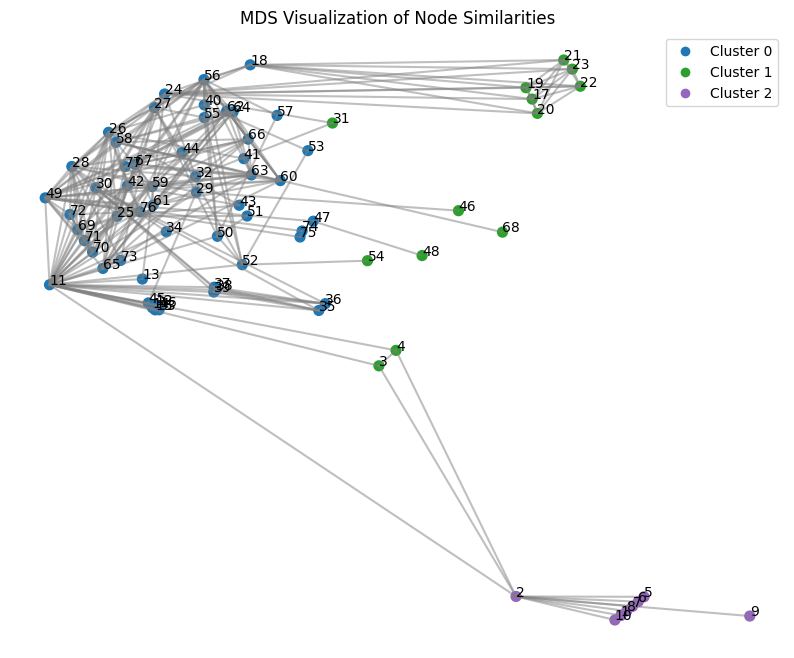

In [19]:
def plot_mds(distances, node_list, edge_list):  
    mds = MDS(n_components=2,max_iter=2000)
    embeddings = mds.fit_transform(distances)

    kmeans = KMeans(n_clusters=3)
    labels = kmeans.fit_predict(embeddings)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='tab10', s=50, vmin=0, vmax=5) 


    for edge in edge_list:
        u, v = edge
        u_index = node_list.index(u)
        v_index = node_list.index(v)
        plt.plot([embeddings[u_index, 0], embeddings[v_index, 0]], 
                    [embeddings[u_index, 1], embeddings[v_index, 1]], 
                    color='gray', alpha=0.5)

    for i, node_number in enumerate(node_list):
        plt.text(embeddings[i, 0], embeddings[i, 1], node_number, color='black')

    handles, labels = scatter.legend_elements()
    plt.legend(handles, [f'Cluster {i}' for i in range(len(handles))], loc='upper right')

    plt.title('MDS Visualization of Node Similarities')
    plt.xlabel('MDS Dimension 1')
    plt.ylabel('MDS Dimension 2')
    plt.axis('off')
    plt.show()

#nodes, edges, node_list, edge_list, weights = get_data_step6('Datasets/LesMiserables.dot')
#distances = floyd_warshall(node_list, edge_list, weights)
#plot_mds(distances, node_list, edge_list)

# ISOMAP

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/sparse/_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/sparse/_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/sparse/_index.py:102: SparseEfficiencyWarning: Changing the

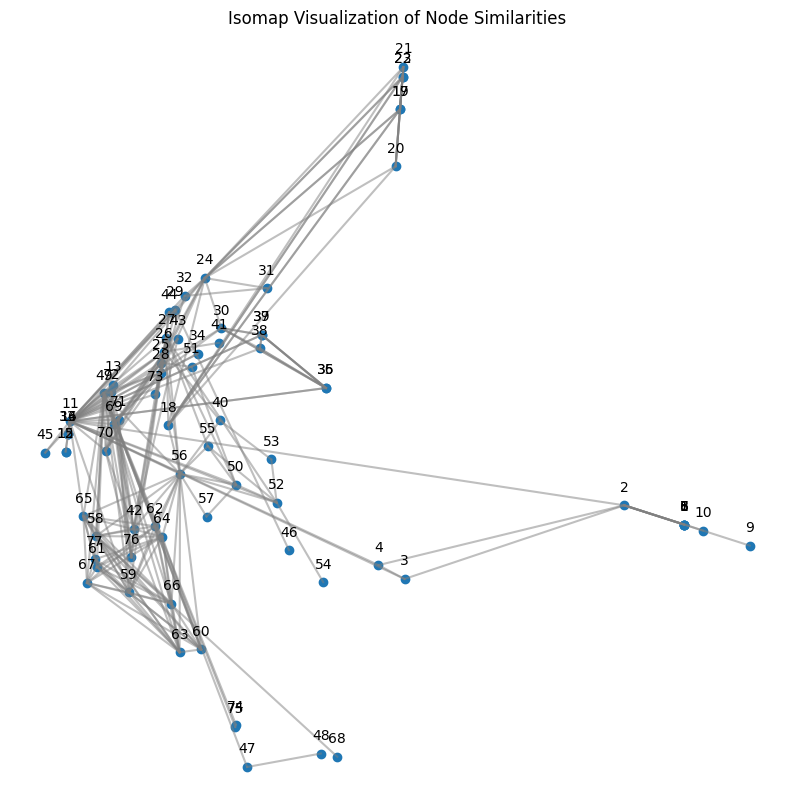

In [22]:
def plot_isomap(similarities, node_list, edge_list):  
    isomap = Isomap(n_components=2, max_iter=1000)
    embeddings = isomap.fit_transform(1 - similarities)

    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings[:, 0], embeddings[:, 1])

    for edge in edge_list:
        u, v = edge
        u_index = node_list.index(u)
        v_index = node_list.index(v)
        plt.plot([embeddings[u_index, 0], embeddings[v_index, 0]], 
                 [embeddings[u_index, 1], embeddings[v_index, 1]], 
                 color='gray', alpha=0.5)

    for i, node_number in enumerate(node_list):
        plt.annotate(node_number, (embeddings[i, 0], embeddings[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.axis('off')
    plt.title('Isomap Visualization of Node Similarities')
    plt.xlabel('Isomap Dimension 1')
    plt.ylabel('Isomap Dimension 2')
    plt.show()

#nodes, edges, node_list, edge_list, weights = get_data_step6('Datasets/LesMiserables.dot')
#distances = floyd_warshall(node_list, edge_list, weights)
#plot_isomap(distances, node_list, edge_list)